In [2]:
import os
import sys

from get_results import getMeasurementsResults

import json
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
import datetime

from ripe.atlas.sagan import (
  TracerouteResult,
  PingResult,
)

from funcy import group_by
import pycountry_convert as pc

%load_ext autoreload
%autoreload 2

In [4]:
us_lozal_zone_measurements = \
[53799832, 53799833, 53799834, 53799835, 53799836, 53799837, 53799838, 53799839, 53799840, 53799841, 53799842, 53799843, 53799844, 53799845, 53799846, 53799847]\
+ [53799850, 53799851, 53799853, 53799854, 53799855, 53799856, 53799857, 53799858, 53799859, 53799860, 53799861, 53799862, 53799863, 53799864, 53799865, 53799866]\
+ [53800035, 53800036, 53800037, 53800038, 53800039, 53800040, 53800041, 53800042, 53800043, 53800044, 53800045, 53800046, 53800047, 53800048, 53800049, 53800050]\
+ [53800051, 53800052, 53800053, 53800054, 53800055, 53800056, 53800057, 53800058, 53800059, 53800060, 53800061, 53800062, 53800063, 53800064, 53800065, 53800066]\
+ [53800099, 53800100, 53800101, 53800102, 53800103, 53800104, 53800105, 53800106, 53800107, 53800108, 53800109, 53800110, 53800111, 53800112, 53800113, 53800114]\
+ [53800120, 53800121, 53800122, 53800123, 53800124, 53800125, 53800126, 53800127, 53800128, 53800129, 53800130, 53800133, 53800134, 53800135, 53800136, 53800137]\
+ [53800171, 53800172, 53800173, 53800174, 53800175, 53800176, 53800177, 53800178, 53800179, 53800180, 53800181, 53800182, 53800183, 53800184, 53800185, 53800186]\
+ [53800188, 53800189, 53800190, 53800191, 53800192, 53800193, 53800194, 53800195, 53800196, 53800197, 53800198, 53800199, 53800200, 53800201, 53800202, 53800203]

us_region_measurements =  \
[53800213, 53800214, 53800215, 53800216]\
+ [53800217, 53800218, 53800219, 53800221]\
+ [53800234, 53800235, 53800236, 53800237]\
+ [53800238, 53800239, 53800240, 53800241]\
+ [53800275, 53800276, 53800277, 53800278]\
+ [53800280, 53800282, 53800283, 53800284]\
+ [53800295, 53800296, 53800297, 53800298]\
+ [53800299, 53800300, 53800301, 53800302]

local_zone_results = getMeasurementsResults(us_lozal_zone_measurements)
region_results = getMeasurementsResults(us_region_measurements)

In [5]:
sns.set_theme()
sns.set_style("whitegrid")

def style_graph_cdf(ax, xlabel='Minimum RTT (ms)'):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel('% of Probes', size=24)
    ax.set_xlabel(xlabel, size=24)
    ax.tick_params(axis='both', which='major', labelsize=18)

def plotCDF(data, ax=plt, **kwargs):
  ax.plot(sorted(data), np.arange(len(data)) / len(data), **kwargs)

def flatten(l):
    return [item for sublist in l for item in sublist]

def removeNulls(l):
    return [x for x in l if x]

def emptyMin(l):
    l = [x for x in l if x]
    if len(l) == 0:
        return None
    return min(l)

def ping_to_rtts(p):
    return [packet.rtt for packet in p.packets]

class ResultWithDescription:
    def __init__(self, description, result):
        self.description = description
        self.result = result

def results_to_rtt_map(results):
    description_to_results = group_by(lambda x: x[0].description, results)
    description_to_results = {description: flatten([result[1] for result in results]) for description, results in description_to_results.items()}
    description_and_results = flatten([[ResultWithDescription(description, result) for result in results] for description, results in description_to_results.items()])
    probe_to_results = group_by(lambda x: x.result.probe_id, description_and_results)
    probe_to_results = {probe_id: group_by(lambda x: x.description, description_and_results) for probe_id, description_and_results in probe_to_results.items()}
    probe_to_results = {probe_id: {name: [m.result for m in description_and_results] for name, description_and_results in results.items()} for probe_id, results in probe_to_results.items()}
    probe_to_results = {probe_id: {name: flatten([ping_to_rtts(r) for r in m]) for name, m in measurements.items()} for probe_id, measurements in probe_to_results.items()}
    return {probe_id: results for probe_id, results in probe_to_results.items() if len(removeNulls(results)) > 0}

def get_medians(probe_to_all_rtts):
    median_rtts = []
    for probe_id, rtts in probe_to_all_rtts.items():
        min_key = ''
        min_value = 10000
        for key, values in rtts.items():
            values = removeNulls(values)
            if len(values) > 0 and min(values) < min_value:
                min_value = min(values)
                min_key = key
        if min_key != '':
            median_rtts.append(np.median(removeNulls(rtts[min_key])))
    return median_rtts

# Figure 2

Results from 1392 probes
7885687


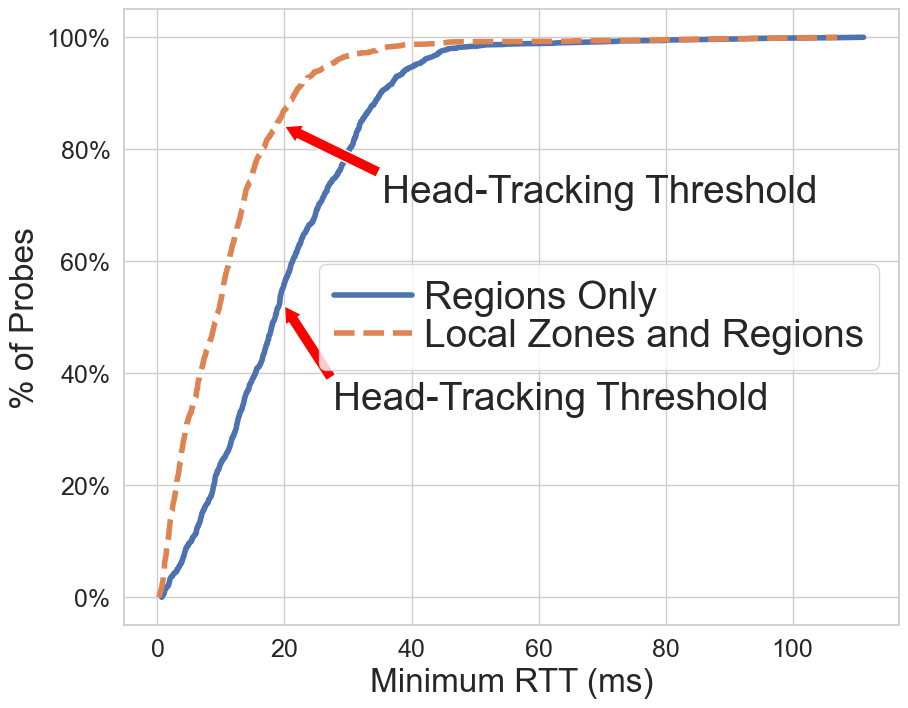

In [6]:
lz_rtts = results_to_rtt_map(local_zone_results+region_results)
region_rtts = results_to_rtt_map(region_results)
print(f"Results from {len(lz_rtts.keys())} probes")
measurements_per_probe = [sum([len(m) for d, m in r.items()]) for probe_id, r in lz_rtts.items()]
print(sum(measurements_per_probe))

fig, ax = plt.subplots(figsize=(10, 8))
median_lz_rtts = get_medians(lz_rtts)
median_region_rtts = get_medians(region_rtts)
min_lz_rtts = {probe_id: emptyMin(flatten(rtts.values())) for probe_id, rtts in lz_rtts.items()}
min_region_rtts = {probe_id: emptyMin(flatten(rtts.values())) for probe_id, rtts in region_rtts.items()}
plotCDF(min_region_rtts.values(), ax=ax, label='Regions Only', linewidth=4)
plotCDF(min_lz_rtts.values(), ax=ax, label='Local Zones and Regions', linewidth=4, linestyle='--')

ax.annotate('Head-Tracking Threshold',
            xy=(20, 0.84), xycoords='data', fontsize='28',
            xytext=(70, -60), textcoords='offset points',
            arrowprops=dict(facecolor='red', width=8, headwidth=14),
            horizontalalignment='left', verticalalignment='bottom')

ax.annotate('Head-Tracking Threshold',
            xy=(20, 0.52), xycoords='data', fontsize='28',
            xytext=(35, -80), textcoords='offset points',
            arrowprops=dict(facecolor='red', width=8, headwidth=14),
            horizontalalignment='left', verticalalignment='bottom')

style_graph_cdf(ax)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="right",
)
fig.savefig('./images/local_zone_speedup.png', dpi=300, bbox_inches='tight')

In [7]:
accelerator_pings = \
[53384781, 53384782, 53384783]\
+ [53384784, 53384785, 53384786]\
+ [53384787, 53384788, 53384789]\
+ [53384790, 53384791, 53384792]\
+ [53384794, 53384795, 53384796]\
+ [53391063, 53391064, 53391065]\
+ [53391066, 53391067, 53391068]\
+ [53391069, 53391070, 53391071]\
+ [53391072, 53391073, 53391074]\
+ [53391076, 53391077, 53391078]\
+ [53391025, 53391026, 53391027]\
+ [53391028, 53391029, 53391030]\
+ [53391031, 53391032, 53391033]\
+ [53391035, 53391036, 53391037]\
+ [53391038, 53391039, 53391040]\
+ [53391043, 53391044, 53391045]\
+ [53391046, 53391047, 53391048]\
+ [53391050, 53391051, 53391052]\
+ [53391053, 53391054, 53391055]\
+ [53391056, 53391057, 53391058]

accelerator_results = getMeasurementsResults(accelerator_pings)

baseline_measurement_ids =\
[54510748]\
+[54510757]\
+[54510770, 54510771, 54510772, 54510773, 54510774, 54510776, 54510777, 54510778, 54510781, 54510782, 54510785, 54510786, 54510788, 54510789, 54510790, 54510792, 54510793, 54510794, 54510797, 54510798, 54510799, 54510801, 54510802, 54510804, 54510805, 54510806, 54510812, 54510814, 54510816, 54510818, 54510819, 54510820, 54510823, 54510824, 54510826, 54510827, 54510829, 54510830]\
+[54510864, 54510866, 54510868, 54510869, 54510870, 54510871, 54510872, 54510874, 54510875, 54510877, 54510878, 54510880, 54510882, 54510895, 54510898, 54510900, 54510901, 54510902, 54510903, 54510904, 54510905, 54510907, 54510910, 54510911, 54510912, 54510913, 54510915, 54510916, 54510917, 54510918, 54510921, 54510922, 54510924, 54510926, 54510930, 54510932, 54510933, 54510935, 54510936, 54510938, 54510939, 54510940, 54510942, 54510945, 54510946, 54510947, 54510948, 54510949, 54510950, 54510952, 54510953, 54510956, 54510958, 54510959, 54510961, 54510962, 54510963, 54510965, 54510967, 54510969]\
+[54510981, 54510986, 54510988, 54510989, 54510990, 54510991, 54510992, 54510994, 54510996, 54510997, 54510999, 54511000, 54511002, 54511003, 54511005, 54511006, 54511007, 54511008, 54511010, 54511011, 54511013, 54511015, 54511016, 54511017, 54511019, 54511020, 54511021, 54511022, 54511025, 54511026, 54511027, 54511028, 54511029, 54511031, 54511033, 54511034, 54511035, 54511037, 54511040, 54511041]\
+[54511049, 54511050, 54511051, 54511053, 54511054, 54511055, 54511058, 54511059, 54511060, 54511061, 54511064, 54511065, 54511066, 54511067, 54511068, 54511071, 54511072, 54511079, 54511081, 54511082, 54511084, 54511085, 54511087, 54511088, 54511089, 54511092, 54511093, 54511094, 54511095, 54511096, 54511098, 54511100, 54511102, 54511103, 54511105, 54511107, 54511109, 54511110, 54511112, 54511114]\
+[54511181, 54511183, 54511184, 54511185, 54511188, 54511189, 54511190, 54511192, 54511193, 54511195, 54511196, 54511198, 54511200, 54511201, 54511203, 54511204, 54511206, 54511207, 54511208, 54511209, 54511210, 54511212, 54511214, 54511217, 54511218, 54511220, 54511221, 54511223, 54511224, 54511225, 54511227, 54511228, 54511230, 54511233, 54511235, 54511236, 54511237, 54511239, 54511240, 54511241]\
+[54511278, 54511280, 54511282, 54511283, 54511285, 54511286, 54511287, 54511289, 54511290, 54511292, 54511293, 54511295, 54511296, 54511297, 54511299, 54511300, 54511301, 54511303, 54511304, 54511305, 54511307, 54511308, 54511310, 54511311, 54511313, 54511316, 54511317, 54511318, 54511319, 54511320, 54511321, 54511323, 54511324, 54511326, 54511327, 54511329, 54511331, 54511332, 54511334, 54511335, 54511337, 54511338, 54511339, 54511340, 54511341, 54511343, 54511344, 54511346, 54511348, 54511349, 54511350, 54511351, 54511353, 54511355, 54511356, 54511358, 54511359, 54511360, 54511362, 54511363]\
+[54511373, 54511375, 54511376, 54511378, 54511379, 54511380, 54511381, 54511382, 54511385, 54511388, 54511389, 54511390, 54511392, 54511394, 54511395, 54511396, 54511398, 54511399, 54511400, 54511402, 54511403, 54511404, 54511406, 54511408, 54511409, 54511410, 54511411, 54511414, 54511415, 54511417, 54511418, 54511419, 54511420, 54511422, 54511423, 54511425, 54511426, 54511427, 54511429, 54511432, 54511433, 54511434, 54511440, 54511441, 54511442, 54511443, 54511444, 54511446, 54511447, 54511449, 54511451, 54511452, 54511454, 54511455, 54511456, 54511458, 54511459, 54511460, 54511461, 54511462]\
+[54511466, 54511467, 54511468, 54511469, 54511471, 54511472, 54511473, 54511475, 54511477, 54511478, 54511480, 54511482, 54511486, 54511488, 54511490, 54511491, 54511492, 54511494, 54511495, 54511497, 54511498, 54511499, 54511500, 54511501, 54511503, 54511505, 54511506, 54511507, 54511509, 54511512, 54511513, 54511514, 54511515, 54511528, 54511530, 54511531, 54511532, 54511533, 54511536, 54511538, 54511539, 54511540, 54511541, 54511543, 54511544, 54511545, 54511546, 54511549, 54511551, 54511552, 54511553, 54511554, 54511556, 54511557, 54511558, 54511560, 54511562, 54511564, 54511566, 54511568]
baseline_measurement_results = getMeasurementsResults(baseline_measurement_ids)

In [8]:
def getProbe(probe_id):
    filename = f'./probes/{probe_id}.json'
    if os.path.exists(filename):
        f = open(filename, 'r')
        data = json.load(f)
        f.close()
        return data

    url = f'https://atlas.ripe.net/api/v2/probes/{probe_id}'
    r = requests.get(url)
    data = r.json()
    
    f = open(filename, 'w')
    json.dump(data, f)
    f.close()
    return data

def getRttMap(measurement_results):
    probe_id_to_rtt_map = {}
    for measurement_result in measurement_results:
        for result in measurement_result[1]:
            if not result.probe_id in probe_id_to_rtt_map:
                probe_id_to_rtt_map[result.probe_id] = {}
            if not result.destination_address in probe_id_to_rtt_map[result.probe_id]:
                probe_id_to_rtt_map[result.probe_id][result.destination_address] = []
            probe_id_to_rtt_map[result.probe_id][result.destination_address].extend([p.rtt for p in result.packets])
    return probe_id_to_rtt_map

def getMinPings(probe_id_to_rtt_map):
    probe_id_to_min_ips = {}
    for probe_id, rtt_map in list(probe_id_to_rtt_map.items()):
        min_pings = {key: emptyMin(value) for key, value in rtt_map.items()}
        min_pings = {key: value for key, value in min_pings.items() if value}
        sorted_min_pings = sorted(list(min_pings.items()), key=lambda x: x[1])
        probe_id_to_min_ips[probe_id] = sorted_min_pings
    return probe_id_to_min_ips

In [9]:
baseline_min = getMinPings(getRttMap(baseline_measurement_results))
continent_baseline_results = {}
for probe_id, value in baseline_min.items():
    probe = getProbe(probe_id)
    continent = pc.country_alpha2_to_continent_code(probe['country_code'])
    if not continent in continent_baseline_results:
        continent_baseline_results[continent] = []

    continent_baseline_results[continent].append(value[0][1])

# Figure 3 and Table 1

Results from 4811 probes
4062842
[22.7, 17.57, 35.87, 44.57, 50.18, 72.83]
[16.21, 12.9, 15.97, 34.79, 24.47, 41.63]
['6.49 (28.59%)', '4.67 (26.58%)', '19.9 (55.48%)', '9.78 (21.94%)', '25.71 (51.24%)', '31.2 (42.84%)']
['4.09 (32.98%)', '3.76 (34.81%)', '8.07 (53.66%)', '3.63 (34.87%)', '14.13 (55.41%)', '24.85 (57.93%)']


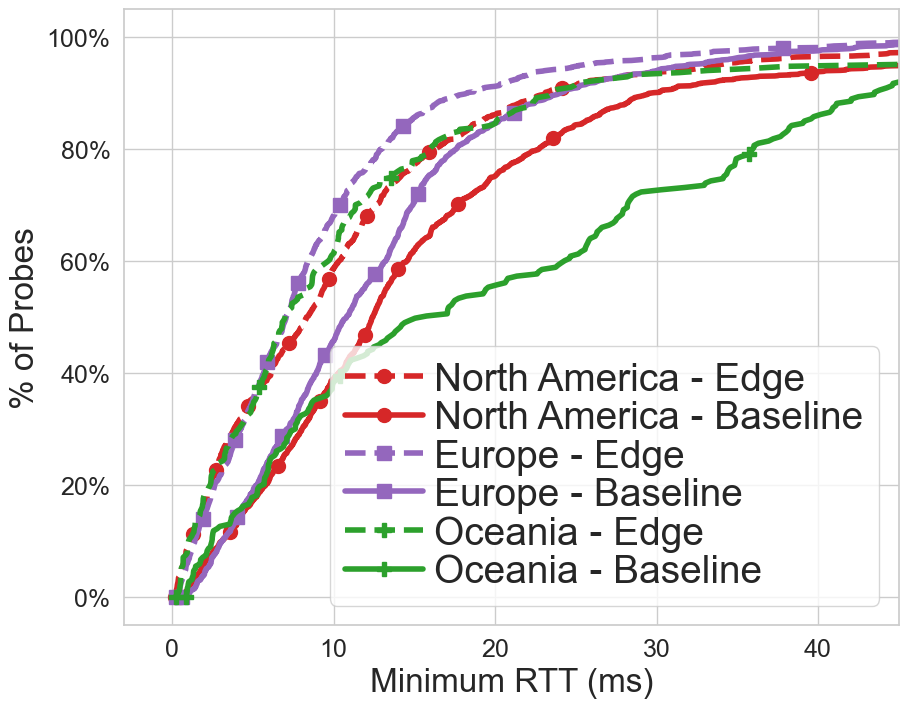

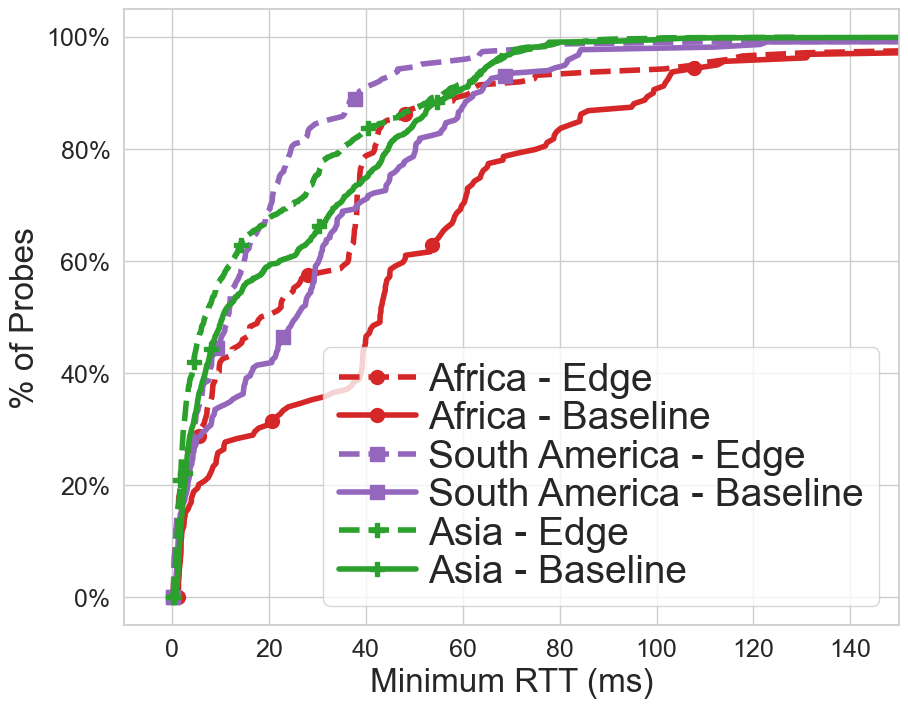

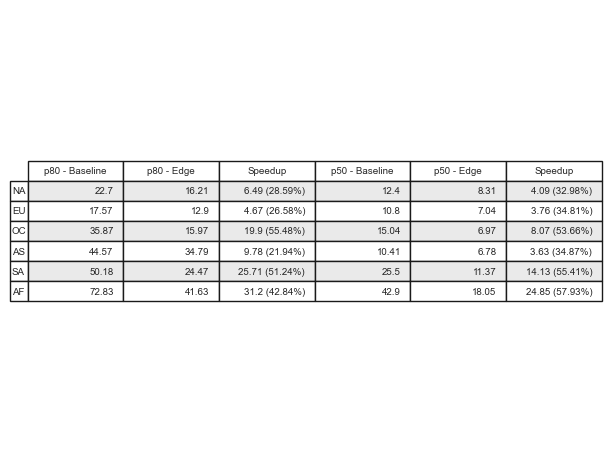

In [10]:
results = results_to_rtt_map(accelerator_results)
print(f"Results from {len(results.keys())} probes")
measurements_per_probe = [sum([len(m) for d, m in r.items()]) for probe_id, r in results.items()]
print(sum(measurements_per_probe))

def safe_continent_code(c):
    try:
        return pc.country_alpha2_to_continent_code(c)
    except:
        return None

def continentForProbeId(probe_id):
    c = getProbe(probe_id)['country_code']
    return safe_continent_code(c)

continent_to_results = {}
for probe_id, rtts in results.items():
    c = continentForProbeId(probe_id)
    if not c in continent_to_results:
        continent_to_results[c] = {}
    continent_to_results[c][probe_id] = rtts
    
def continent_code_to_name(c):
    if c == "NA":
        return "North America"
    if c == "EU":
        return "Europe"
    if c == "OC":
        return "Oceania"
    if c == "SA":
        return "South America"
    if c == "AF":
        return "Africa"
    if c == "AS":
        return "Asia"

cmap = plt.colormaps["tab10"]([0, 1, 2, 3, 4, 5])

def continent_code_to_color(c):
    if c == "NA" or c == "AF":
        return cmap[3]
    if c == "EU" or c == "SA":
        return cmap[4]
    if c == "OC" or c == "AS":
        return cmap[2]

def continent_code_to_marker(c):
    if c == "NA" or c == "AF":
        return 'o'
    if c == "EU" or c == "SA":
        return 's'
    if c == "OC" or c == "AS":
        return 'P'

def continent_code_to_marker_every(c):
    if c == "NA" or c == "EU" or c == "AS":
        return 200
    if c == "OC" or c == "SA":
        return 100
    if c == "AF":
        return 50

fig, ax = plt.subplots(figsize=(10, 8))
latencies = {}
for c in ["NA", "EU", "OC"]:
    results = continent_to_results[c]
    min_rtts = {probe_id: emptyMin(flatten(rtts.values())) for probe_id, rtts in results.items()}
    latencies[c] = min_rtts.values()
    plotCDF(min_rtts.values(), ax=ax, label=f"{continent_code_to_name(c)} - Edge", linewidth=4, color=continent_code_to_color(c), linestyle='--', marker=continent_code_to_marker(c), markevery=continent_code_to_marker_every(c), markersize=10)
    plotCDF(continent_baseline_results[c], label=f"{continent_code_to_name(c)} - Baseline", ax=ax, linewidth=4, color=continent_code_to_color(c), marker=continent_code_to_marker(c), markevery=continent_code_to_marker_every(c), markersize=10)
style_graph_cdf(ax)
ax.set_xlim(-3, 45)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="lower right",
)
fig.savefig('./images/na_eu_oc_speeds.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8))
for c in ["AF", "SA", "AS"]:
    results = continent_to_results[c]
    min_rtts = {probe_id: emptyMin(flatten(rtts.values())) for probe_id, rtts in results.items()}
    latencies[c] = min_rtts.values()
    plotCDF(min_rtts.values(), ax=ax, label=f"{continent_code_to_name(c)} - Edge", linewidth=4, color=continent_code_to_color(c), linestyle='--', marker=continent_code_to_marker(c), markevery=continent_code_to_marker_every(c), markersize=10)
    plotCDF(continent_baseline_results[c], label=f"{continent_code_to_name(c)} - Baseline", ax=ax, color=continent_code_to_color(c), linewidth=4, marker=continent_code_to_marker(c), markevery=continent_code_to_marker_every(c), markersize=10)
style_graph_cdf(ax)
ax.set_xlim(-10, 150)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="lower right",
)
fig.savefig('./images/af_sa_as_speeds.png', dpi=300, bbox_inches='tight')


continents = ["NA", "EU", "OC", "AS", "SA", "AF"]
baselines = [continent_baseline_results[c] for c in continents]
new_measurements = [list(latencies[c]) for c in continents]
p80Baselines = [round(np.percentile(l, 80), 2) for l in baselines]
print(p80Baselines)
p80New = [round(np.percentile(l, 80), 2) for l in new_measurements]
print(p80New)
p50Baselines = [round(np.percentile(l, 50), 2) for l in baselines]
p50New = [round(np.percentile(l, 50), 2) for l in new_measurements]

p80Speedup = [f'{round(b-n, 2)} ({round((b-n)/b * 100, 2)}%)' for b, n in zip(p80Baselines, p80New)]
p50Speedup = [f'{round(b-n, 2)} ({round((b-n)/b * 100, 2)}%)' for b, n in zip(p50Baselines, p50New)]

print(p80Speedup)
print(p50Speedup)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
grays = plt.colormaps["Greys"]([40])
ax.table(np.transpose([p80Baselines, p80New, p80Speedup, p50Baselines, p50New, p50Speedup]), rowLabels = continents, colLabels = ["p80 - Baseline", "p80 - Edge", "Speedup", "p50 - Baseline", "p50 - Edge", "Speedup"], cellColours = [[grays[0]] * 6, [[1, 1, 1]] * 6] * 3, figure=fig, loc='center', fontsize=80)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('images/table.png', dpi=300)
plt.show()

In [11]:
traceroute_measurement_ids = [53391568, 53391569, 53391571, 53391572, 53391573, 53391577, 53391579, 53391580, 53391582]\
+ [53391583, 53391596, 53391599, 53391601, 53391603, 53391606, 53391610, 53391612, 53391614, 53391616, 53391618]
traceroute_results = getMeasurementsResults(traceroute_measurement_ids, TracerouteResult)

In [12]:
from cymruwhois import Client
from ipwhois import IPWhois
import signal
import ipaddress

def handler(signum, frame):
  raise Exception("end of time")

def ip_entity(address):
    if not address or ipaddress.ip_address(address).is_private:
        return None
    try:
          signal.signal(signal.SIGALRM, handler)
          signal.alarm(2)
          whois_res = IPWhois(address).lookup_rdap(asn_methods=["whois"])
          signal.alarm(0)
          return whois_res["entities"][0]
    except Exception as e:
      return None

def tracerouteMinRtt(measurement):
  rtts = [x.rtt for x in measurement.hops[-1].packets if x.rtt and x.origin == measurement.destination_address]
  if len(rtts) == 0:
    return None
  return min(rtts)

def is_amzn_asn(asn):
    if asn[0] and asn[0] == '16509':
        return True
    return asn[1] and ("AT-88-Z" == asn[1] or "AMAZO" in asn[1])

def originFromHop(hop):
   if len(hop.packets) == 0:
      return None
   return hop.packets[0].origin

ip_mapping_path = './ip_mappings.txt'

ip_mappings_data = {}
def regenIPMappingsData():
  global ip_mappings_data
  f = open(ip_mapping_path, 'r')
  ip_mappings_data = json.load(f)
  f.close()

def getIPMappingsData():
  if len(ip_mappings_data.keys()) == 0:
    regenIPMappingsData()
  return ip_mappings_data

def saveIPListToASNInfo(ips):
  c = Client()
  asnLookups = list(c.lookupmany(filter(None, ips)))
  asnDict = {}
  results = {}
  for asnResult in asnLookups:
    asnDict[asnResult.ip] = asnResult
  for ip in ips:
    if not ip or ipaddress.ip_address(ip).is_private:
        continue

    entity = None
    asn = None
    if ip in asnDict:
      if asnDict[ip].asn != 'NA':
        asn = asnDict[ip].asn
    entity = ip_entity(ip)
    results[ip] = {'entity': entity, 'asn': asn}
  return results

def getASNInfo(ip):
    data = getIPMappingsData()
    if ip in data:
      return data[ip]
    if ipaddress.ip_address(ip).is_private:
      return None
    else:
      try:
        asnInfo = saveIPListToASNInfo([ip])[ip]
        data[ip] = asnInfo
        f = open(ip_mapping_path, 'w')
        json.dump(data, f)
        f.close()
        return asnInfo
      except:
         return {}

def getASNs(mes):
    hops = mes.hops
    ips = list(map(lambda x: originFromHop(x), hops))
    latencies = list(map(lambda x: emptyMin(list(filter(None, map(lambda x: x.rtt, x.packets)))), hops))
    all_asns = []
    for (ip, latency) in zip(ips, latencies):
      if ip:
        asnInfo = getASNInfo(ip)
        if asnInfo:
            all_asns.append([asnInfo['asn'], asnInfo['entity'], latency, ip])
    return all_asns

def updateIpsInfo(ips):
  data = getIPMappingsData()
  not_seen_ips = [ip for ip in ips if ip not in data]
  if len(not_seen_ips) == 0:
    return

  asnInfo = saveIPListToASNInfo(not_seen_ips)
  for ip, info in asnInfo.items():
     data[ip] = info
  f = open(ip_mapping_path, 'w')
  json.dump(data, f)
  f.close()

def amazon_time(measurement):
    asns = getASNs(measurement)
    if len(asns) == 0:
      return None
    totalTime = asns[-1][2]
    for asn in asns:
        if is_amzn_asn(asn):
            amazonTime = totalTime - asn[2]
            nonAmazonTime = asn[2]
            return [amazonTime, nonAmazonTime]
    return None

In [13]:
traceroute_measurements = flatten([x[1] for x in traceroute_results])

# Cache ip to ASN info, this can take a long time
# try:
#     # Create the file if it doesn't exist
#     f = open(ip_mapping_path, "x")
#     json.dump({}, f)
#     f.close()
# except:
#     pass
ips = list(set(flatten([list(map(lambda x: originFromHop(x), mes.hops)) for mes in traceroute_measurements])))
def chunk(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
groups = list(chunk(ips, 100))
for group in groups:
    updateIpsInfo(group)

getting list for #['10.82.1.50', '172.17.1.207', '172.18.67.114', '172.16.0.101', '10.254.0.169', '10.144.0.1', '10.3.72.1', '172.17.22.204', '10.55.1.1', '192.168.157.1', '10.25.25.142', '10.11.11.17', '172.30.250.1', '10.21.252.18']
getting list for #['172.16.48.1', '10.169.152.42', '10.128.17.222', '10.68.192.1', '10.79.1.6', '192.168.210.254', '192.168.123.11', '10.103.123.44', '172.16.138.48', '172.19.14.13', '10.137.216.81', '172.24.4.1', '10.10.12.61', '10.97.1.1', '10.254.0.38']
getting list for #['10.20.204.1', '172.27.29.122', '192.168.12.10', '172.29.121.1', '10.4.0.9', '172.18.0.16', '10.40.138.202', '10.10.51.1', '10.0.104.1', '192.168.45.1', '10.220.99.20', '10.11.17.81', '172.17.80.165', '10.9.196.1', '10.253.250.58', '10.200.3.210', '10.11.20.241', '10.200.2.85', '10.4.0.11', '10.254.2.2', '172.17.50.18', '10.13.110.17', '192.168.142.1']
getting list for #['10.111.222.1', '10.10.12.49', '172.16.250.64', '10.0.0.23', '172.17.0.2', '172.19.15.1', '192.168.11.77', '10.80.3

In [14]:
def groupByContinents(ds):
  ds = {k: [pc.country_alpha2_to_continent_code(vs[0]['country_code']), vs[1]] for k, vs in ds.items()}
  ds = group_by(lambda x: x[0], [(vs[0], vs[1]) for k, vs in ds.items()])
  return {k: sorted([v[1] for v in vs]) for k, vs in ds.items()}

ds = [(d.probe_id, [amazon_time(d), tracerouteMinRtt(d)]) for d in traceroute_measurements]
ds = group_by(lambda x: x[0], [(d[0], d[1]) for d in ds])
ds = {k: [v[1] for v in vs if v[1][0] != None and v[1][1] != None] for k, vs in ds.items()}
ds = {k: [getProbe(k), [min([v[0][1] for v in vs]), min([v[1] for v in vs])]] for k, vs in ds.items() if len(vs) > 0}
grouped_results = groupByContinents(ds)

# Figure 4

90.19158683881716% over -1ms


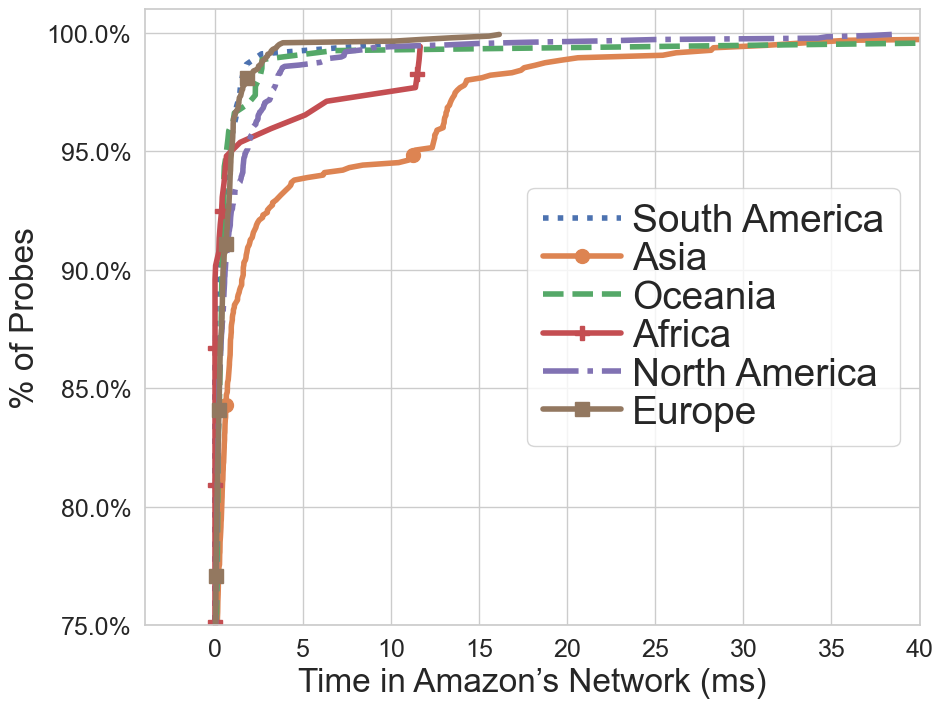

In [19]:
def nonNegativePercentage(l, epsilon=1):
    s = sorted(l)
    non_negative_length = len([a for a in s if a > 0-epsilon])
    return non_negative_length/len(l)

def continentToStyle(continent):
    if continent == 'oc':
        return '--'
    if continent == 'na':
        return '-.'
    if continent == 'sa':
        return ':'
    return '-'

def continent_code_to_marker(c):
    if c == "as":
        return 'o'
    if c == "eu":
        return 's'
    if c == "af":
        return 'P'
    return None

fig, ax = plt.subplots(figsize=(10, 8))
saResults = [x[1] - x[0] for x in grouped_results['SA']]
asResults = [x[1] - x[0] for x in grouped_results['AS']]
ocResults = [x[1] - x[0] for x in grouped_results['OC']]
afResults = [x[1] - x[0] for x in grouped_results['AF']]
naResults = [x[1] - x[0] for x in grouped_results['NA']]
euResults = [x[1] - x[0] for x in grouped_results['EU']]
print(f"{nonNegativePercentage(saResults + asResults + ocResults + afResults + naResults + euResults) * 100}% over -1ms")
plotCDF(saResults, label="South America", ax=ax, linewidth=4, linestyle=continentToStyle('sa'), marker=continent_code_to_marker('sa'), markevery=100, markersize=10)
plotCDF(asResults, label="Asia", ax=ax, linewidth=4, linestyle=continentToStyle('as'), marker=continent_code_to_marker('as'), markevery=100, markersize=10)
plotCDF(ocResults, label="Oceania", ax=ax, linewidth=4, linestyle=continentToStyle('oc'), marker=continent_code_to_marker('oc'), markevery=100, markersize=10)
plotCDF(afResults, label="Africa", ax=ax, linewidth=4, linestyle=continentToStyle('af'), marker=continent_code_to_marker('af'), markevery=10, markersize=10)
plotCDF(naResults, label="North America", ax=ax, linewidth=4, linestyle=continentToStyle('na'), marker=continent_code_to_marker('na'), markevery=100, markersize=10)
plotCDF(euResults, label="Europe", ax=ax, linewidth=4, linestyle=continentToStyle('eu'), marker=continent_code_to_marker('eu'), markevery=100, markersize=10)
style_graph_cdf(ax, xlabel='Time in Amazon’s Network (ms)')
ax.set_ylim(0.75, 1.01)
ax.set_xlim(-4, 40)
ax.legend(
    labelspacing=0.06,
    columnspacing=0.5,
    handletextpad=0.3,
    ncol=1,
    fontsize="28",
    loc="right",
)
plt.savefig('images/amazon_time.png', bbox_inches='tight', dpi=300)